In [ ]:
from phaseedge.sampling.wl_block_driver import fetch_wl_tip
from phaseedge.storage.store import build_jobstore

js = build_jobstore()

# Query ALL CEModelDocs (payload is under "output" in your DB); load=True rehydrates big fields.
rows = js.query(criteria={"output.kind": "WLBlockDoc"}, load=True)
rows = list(rows)  # force evaluation
print("count:", len(rows))

# Print the first ce_key (rehydrated)
for row in rows[:10]:
    doc = row["output"]
    tip = fetch_wl_tip(doc.get("wl_key"))
    print("wl_key:", doc.get("wl_key"), "found:" , tip is not None)


count: 10
wl_key: eebff3606060fbd1c3b525bd60b7c2e26f333e9ccd19d7fe8f3115db19b8c575 found: True
wl_key: e7117dbf8f00537f5668ed8a810301a630854c2727d6618e40d41fb67e1fe3ac found: True
wl_key: 2966337c7a2d1ae2848dde66429c3327c40f8bdd1eda53772f1273228a6a12b5 found: True
wl_key: d7883eaddcc3442773685867d2dadacbb8a39c6f22b98f215ac6de4dbade96fa found: True
wl_key: 44b143a515db91f4dc19e8977b0fb522b7d48c29a1de57d35d04ca839dc3c258 found: True
wl_key: b31cc6d1cf1b8e8cb7c1776acf0b3656246f14d9215b5491307e8e9c57c27b47 found: True
wl_key: d3b8322a49278812dc8b315843ecd80644fb458ce78b73657a8d352f8f818351 found: True
wl_key: d7bd7ffbf676c244a5444abd0095a512cbdfe822f164f11053762f55e0339ed2 found: True
wl_key: 8e23030bc418651a7b55a6090abe34aff887b8ecf4dbefe5de46a97b6666b34b found: True
wl_key: 27a954af531715d900479d28e4363dc3b09a8ad9270b3983311367bc34fb2e89 found: True


visited bins: 169 | ΔE=0.1
total steps (chain tip): 25,000,000
current _m (ln f): 1.52588e-05  (target ≈ 1e-7)
stage histogram sum: 2350000 | cumulative occurrences sum: 25000000
sample capture: none recorded in this block


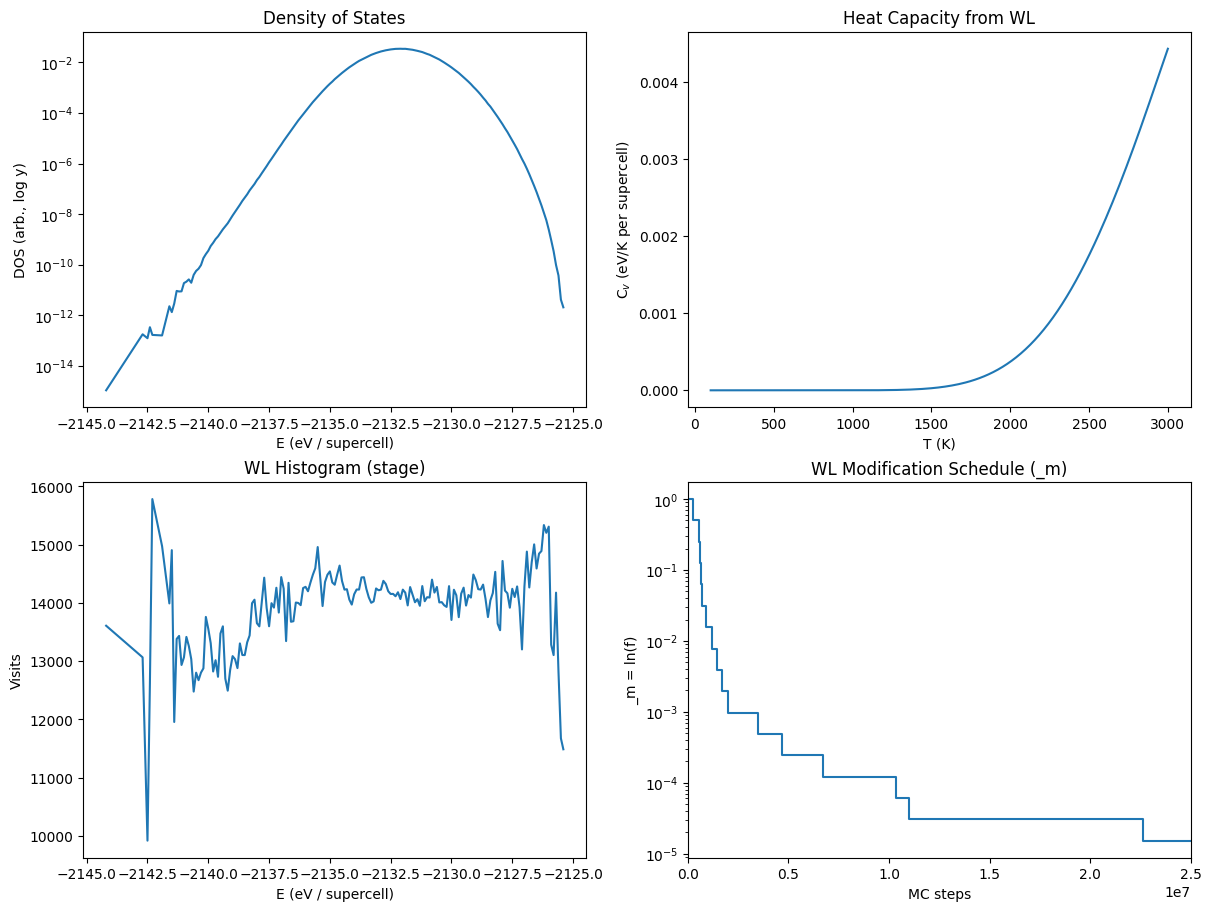

In [24]:
from typing import Any, Mapping, TypedDict, List, Dict
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from phaseedge.sampling.wl_block_driver import fetch_wl_tip
from phaseedge.storage.store import build_jobstore

# ----------------------------- types ---------------------------------------

class WLData(TypedDict):
    levels: np.ndarray
    entropy: np.ndarray
    histogram: np.ndarray          # stage-local (resets at flatness)
    occurrences: np.ndarray        # cumulative (never resets; may be absent in older ckpts)
    bin_indices: np.ndarray
    dE: float
    anchor: float
    m_log: float                   # current _m = ln(f)
    block: Mapping[str, Any]


# ----------------------------- loaders ------------------------------------

def load_wl_latest_from_chain(wl_key: str) -> WLData:
    block = fetch_wl_tip(wl_key)
    if not block:
        raise RuntimeError(f"No blocks found for wl_key={wl_key!r}.")
    s: Mapping[str, Any] = block["state"]

    bins: np.ndarray = np.asarray(s["bin_indices"], dtype=int)
    entropy: np.ndarray = np.asarray(s["entropy"], dtype=float)
    hist: np.ndarray = np.asarray(s["histogram"], dtype=int)
    occs_raw = s.get("occurrences", [])
    occs: np.ndarray = (
        np.asarray(occs_raw, dtype=int)
        if isinstance(occs_raw, (list, tuple))
        else np.zeros_like(hist)
    )

    anchor: float = 0.0
    dE: float = float(s["bin_size"])
    levels: np.ndarray = anchor + dE * bins.astype(float)

    order = np.argsort(bins)
    return WLData(
        levels=levels[order],
        entropy=entropy[order],
        histogram=hist[order],
        occurrences=occs[order] if occs.size else np.zeros_like(hist[order]),
        bin_indices=bins[order],
        dE=dE,
        anchor=anchor,
        m_log=float(s["mod_factor"]),  # _m = ln(f)
        block=block,
    )



def load_mod_schedule(wl_key: str, m0: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Concatenate per-block updates into a global schedule of _m (ln f),
    loading WL blocks from the Jobflow outputs store.

    Returns
    -------
    steps : np.ndarray[int]
        Monotone, starting at 0.
    m_vals : np.ndarray[float]
        Same length as steps; m at each change point.
    """
    js = build_jobstore()
    rows = list(
        js.docs_store.query(
            criteria={"output.kind": "WLBlockDoc", "output.wl_key": wl_key},
            properties={
                "_id": 0,
                "output.state.mod_factor": 1,
                "output.mod_updates": 1,
                "output.step_end": 1,
            },
            sort={"output.step_end": 1},
        )
    )
    if not rows:
        raise RuntimeError(f"No WL blocks found for wl_key={wl_key!r}.")

    # Prefer the recorded initial m from the first block, else fallback.
    first_out = rows[0].get("output", {})
    state = first_out.get("state") or {}
    m0_eff = float(state.get("mod_factor", m0))

    # Collect (step, m) updates across all blocks
    events: list[tuple[int, float]] = []
    for rec in rows:
        out = rec.get("output", {})
        for ev in out.get("mod_updates", []) or []:
            step = int(ev["step"])
            m = float(ev["m"])
            events.append((step, m))

    if events:
        # Dedup by step; keep the last m encountered for that step.
        step_to_m: dict[int, float] = {}
        for step, m in events:
            step_to_m[step] = m
        sorted_steps = sorted(step_to_m.keys())
        steps = [0] + sorted_steps
        m_vals = [m0_eff] + [step_to_m[s] for s in sorted_steps]
    else:
        tip_steps = int(rows[-1]["output"]["step_end"])
        steps = [0, tip_steps]
        m_vals = [m0_eff, m0_eff]

    return np.asarray(steps, dtype=int), np.asarray(m_vals, dtype=float)


def _extend_stair_to(steps: np.ndarray, vals: np.ndarray, right_x: int) -> tuple[np.ndarray, np.ndarray]:
    """Ensure a step curve extends horizontally to right_x."""
    if steps.size == 0:
        return np.array([0, right_x], dtype=int), np.array([1.0, 1.0], dtype=float)
    if steps[-1] < right_x:
        steps = np.append(steps, right_x)
        vals  = np.append(vals,  vals[-1])
    return steps, vals


# ----------------------------- analysis + plotting ------------------------

def analyze_wl_chain(wl_key: str) -> None:
    wl = load_wl_latest_from_chain(wl_key)
    levels  = wl["levels"]
    entropy = wl["entropy"]
    hist    = wl["histogram"]
    occ_all = wl["occurrences"]
    dE      = wl["dE"]
    steps_total = wl["block"]["step_end"]
    m_current = wl["m_log"]
    steps_m, m_vals = load_mod_schedule(wl_key)

    # DOS from entropy
    S_shift: np.ndarray = entropy - np.max(entropy) if entropy.size else entropy
    DOS: np.ndarray = np.exp(S_shift) if S_shift.size else np.array([])
    if DOS.size:
        DOS /= DOS.sum()

    # Cv(T)
    kB: float = 8.617333262e-5  # eV/K
    E:  np.ndarray = levels.astype(float)
    E_rr: np.ndarray = E - E.min() if E.size else E
    Ts: np.ndarray = np.linspace(100.0, 3000.0, 200)

    def _weights(T: float) -> np.ndarray:
        return np.exp(S_shift - E_rr / (kB * T))

    if E.size:
        Z  = np.array([_weights(T).sum() for T in Ts])
        U  = np.array([(_weights(T) * E).sum() / Z[i] for i, T in enumerate(Ts)])
        U2 = np.array([(_weights(T) * E * E).sum() / Z[i] for i, T in enumerate(Ts)])
        Cv = (U2 - U * U) / (kB * Ts * Ts)
    else:
        Z = U = U2 = Cv = np.array([])

    # ---- reporting ----
    print(f"visited bins: {levels.size} | ΔE={dE}")
    print(f"total steps (chain tip): {steps_total:,}")
    print(f"current _m (ln f): {m_current:.6g}  (target ≈ 1e-7)")
    print(f"stage histogram sum: {int(hist.sum())} | cumulative occurrences sum: {int(occ_all.sum())}")

    # ---- sample statistics (new schema: top-level fields) ----
    bin_samples = wl["block"].get("bin_samples", [])
    samples_per_bin = int(wl["block"]["samples_per_bin"])

    if bin_samples and samples_per_bin > 0:
        bins_to_occ: Dict[int, List[list[int]]] = defaultdict(list)
        for rec in bin_samples:
            try:
                b = int(rec["bin"])
                occ = rec["occ"]
            except Exception:
                continue
            bins_to_occ[b].append(occ)

        n_bins_with_samples = len(bins_to_occ)
        n_bins_full = sum(1 for occs in bins_to_occ.values() if len(occs) >= samples_per_bin)
        total_samples = sum(len(v) for v in bins_to_occ.values())
        mean_per_sampled_bin = (total_samples / n_bins_with_samples) if n_bins_with_samples else 0.0

        print(f"sample capture: {n_bins_with_samples} bins with samples")
        print(f"bins filled to quota ({samples_per_bin}): {n_bins_full}")
        print(f"total stored samples: {total_samples}  (avg {mean_per_sampled_bin:.2f} per sampled bin)")
    else:
        print("sample capture: none recorded in this block")

    # ---- plotting ----
    fig, axs = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

    ax = axs[0, 0]
    if DOS.size:
        eps = 0.0 if np.all(DOS > 0) else 1e-300
        ax.semilogy(E, DOS + eps)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("DOS (arb., log y)")
    ax.set_title("Density of States")

    ax = axs[0, 1]
    if Cv.size:
        ax.plot(Ts, Cv)
    ax.set_xlabel("T (K)")
    ax.set_ylabel("C$_v$ (eV/K per supercell)")
    ax.set_title("Heat Capacity from WL")

    ax = axs[1, 0]
    y_visits = hist if hist.sum() > 0 else occ_all
    label = "Histogram (stage)" if y_visits is hist else "Occurrences (cumulative)"
    if y_visits.size:
        ax.plot(E, y_visits)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("Visits")
    ax.set_title(f"WL {label}")

    ax = axs[1, 1]
    right_x = max(int(steps_total), int(steps_m[-1]) if steps_m.size else 0)
    steps_m_ext, m_vals_ext = _extend_stair_to(steps_m, m_vals, right_x)
    ax.step(steps_m_ext, m_vals_ext, where="post")
    ax.set_xlim(0, right_x)
    ax.set_xlabel("MC steps")
    ax.set_ylabel("_m = ln(f)")
    ax.set_yscale('log')
    ax.set_title("WL Modification Schedule (_m)")

    plt.show()


# ----------------------------- run ----------------------------------------

# Replace with your WL key:
# analyze_wl_chain("") # MgFeO2 3x3x3 refined 50:50
# analyze_wl_chain("") # MgAl2O4 2x2x2 refined
# analyze_wl_chain("4f43349d82a2462e1af28a44f11430df3cf0bfcb01509eadba060c5dfc69edf2") # MgGa2O4 2x2x2 refined
# analyze_wl_chain("80d8c390132405b8ba7a1bb775c35a50ef1fe4acbafd10c247fe3e20a643638c") # ZnAl2O4 2x2x2 refined
analyze_wl_chain("453865df7deffca7d2e6dc2246e8a2fa08683264868486e50a6fd7f03fa1db15") # Sr2TaAlO6 3x3x3 unrefined


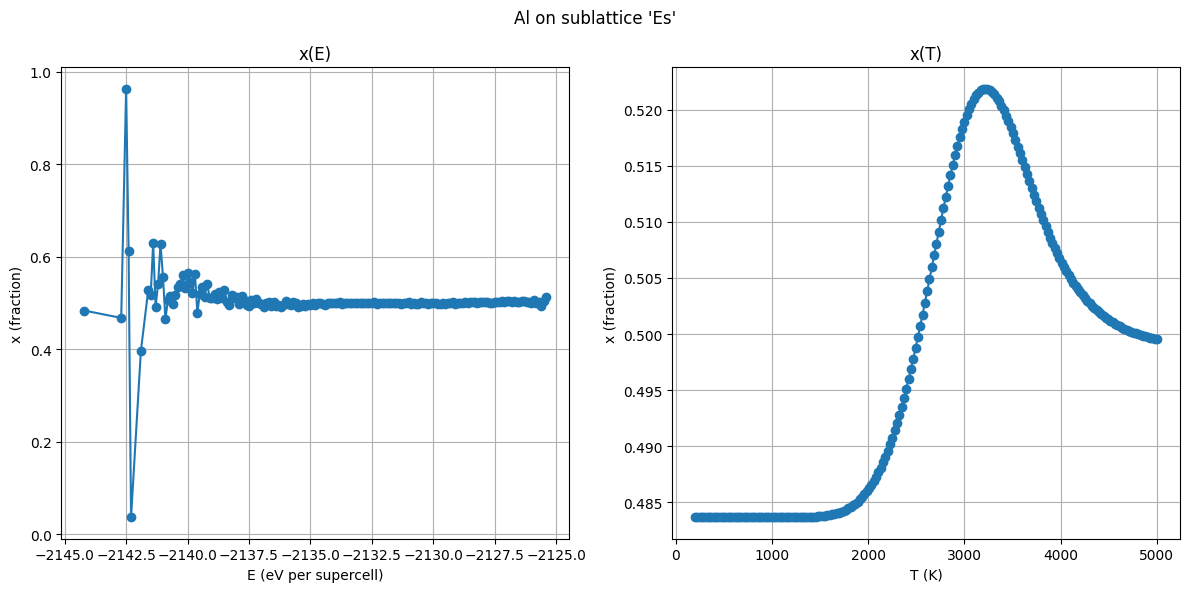

In [29]:
from typing import Any, Mapping

import math
import numpy as np
import matplotlib.pyplot as plt

from phaseedge.sampling.wl_block_driver import fetch_wl_tip


__all__ = ["analyze_wl_chain_tip"]


def analyze_wl_chain_tip(
    wl_key: str,
    *,
    sublattice: str,
    element: str,
    T_grid: list[float],
) -> dict:
    """
    Read tip-of-chain cation composition stats and WL state for a WL key (RO connection),
    validate production mode, compute x(E) and x(T) for a single (sublattice, element),
    and plot a single two-subplot figure: left = x(E), right = x(T).

    Args:
        wl_key: Wang-Landau chain key to query.
        sublattice: Sublattice label to plot (must match what's stored in cation_counts).
        element: String element code to plot.
        T_grid: Temperatures (K) for x(T). Defaults to 200-2000 K, 200 points.
        species_map: Optional {element_code -> pretty label} for plot titles.

    Returns:
        Dict bundle with raw/derived data (same structure as before, plus 'series'):
          {
            "doc_id": str,
            "bin_size": float,
            "bin_indices": np.ndarray[int],
            "entropy": np.ndarray[float],
            "occurrences_map": dict[int, int],
            "E_map": dict[int, float],
            "S_map": dict[int, float],
            "cation_agg": dict[int, dict[str, dict[int, dict[int, int]]]],
            "xE": dict[str, dict[int, dict[int, float]]],
            "xT": dict[str, dict[int, dict[float, float]]],
            "T_grid": list[float],
            "series": {"sublattice": str, "element": str},
          }
    """
    # -------------------------
    # 1) Connect & fetch TIP
    # -------------------------
    doc = fetch_wl_tip(wl_key)
    if doc is None:
        raise ValueError(f"No blocks found for wl_key='{wl_key}'.")
    doc_id = str(doc.get("_id", ""))
    production_mode = bool(doc.get("production_mode", False))
    if not production_mode:
        raise ValueError(
            f"WL Block {doc_id} for wl_key='{wl_key}' is not in production_mode. "
            "Choose a production-mode tip or resume the chain in production mode."
        )

    # -------------------------
    # 2) Extract WL state
    # -------------------------
    state = _get_state(doc)
    bin_indices = np.asarray(state.get("bin_indices", []), dtype=int)
    entropy = np.asarray(state.get("entropy", []), dtype=float)
    occurrences = np.asarray(state.get("occurrences", []), dtype=int)
    bin_size = float(state.get("bin_size", np.nan))

    if not np.isfinite(bin_size) or bin_indices.size == 0 or entropy.size == 0:
        raise ValueError(
            f"Missing/incomplete WL state in block {doc_id}. "
            "Require bin_indices (visited), entropy, and bin_size."
        )

    if occurrences.size != bin_indices.size:
        occ_map: dict[int, int] = {int(b): 0 for b in bin_indices.tolist()}
        n = int(min(occurrences.size, bin_indices.size))
        for i in range(n):
            occ_map[int(bin_indices[i])] = int(occurrences[i])
        occurrences = np.asarray([occ_map[int(b)] for b in bin_indices], dtype=int)

    E_map: dict[int, float] = {int(b): float(b) * bin_size for b in bin_indices.tolist()}
    S_map: dict[int, float] = {int(b): float(entropy[i]) for i, b in enumerate(bin_indices.tolist())}
    occurrences_map: dict[int, int] = {int(b): int(occurrences[i]) for i, b in enumerate(bin_indices.tolist())}

    # -------------------------
    # 3) Extract cation_counts
    # -------------------------
    rows = _get_cation_rows(doc)
    cation_agg = _aggregate_cation_counts(rows)

    # -------------------------
    # 4) Compute x(E)
    # -------------------------
    xE = _compute_xE(cation_agg)

    # -------------------------
    # 5) Compute x(T)
    # -------------------------
    xT = _compute_xT(xE, S_map, E_map, T_grid)

    # -------------------------
    # 6) Single two-subplot figure for (sublattice, element)
    # -------------------------
    _plot_single_xE_xT(
        sublattice=sublattice,
        element=element,
        xE=xE,
        xT=xT,
        E_map=E_map,
    )

    return {
        "doc_id": doc_id,
        "bin_size": bin_size,
        "bin_indices": bin_indices,
        "entropy": entropy,
        "occurrences_map": occurrences_map,
        "E_map": E_map,
        "S_map": S_map,
        "cation_agg": cation_agg,
        "xE": xE,
        "xT": xT,
        "T_grid": list(T_grid),
        "series": {"sublattice": sublattice, "element": element},
    }


# =========================
# Helpers (typed & local)
# =========================

def _get_state(doc: Mapping[str, Any]) -> Mapping[str, Any]:
    """Support 'state' (preferred) and 'kernel_state' (fallback)."""
    state = doc.get("state")
    if isinstance(state, dict):
        return state
    ks = doc.get("kernel_state")
    if isinstance(ks, dict):
        return ks
    return {}


def _get_cation_rows(doc: Mapping[str, Any]) -> list[Mapping[str, Any]]:
    """Pull flattened cation_counts list from the top-level doc (schema_version >= 3)."""
    rows = doc.get("cation_counts")
    if isinstance(rows, list):
        return [r for r in rows if isinstance(r, dict)]
    stats = doc.get("stats")
    if isinstance(stats, dict):
        rows2 = stats.get("cation_counts")
        if isinstance(rows2, list):
            return [r for r in rows2 if isinstance(r, dict)]
    return []


def _aggregate_cation_counts(
    rows: list[Mapping[str, Any]]
) -> dict[int, dict[str, dict[str, dict[int, int]]]]:
    """
    Aggregate cation rows into:
      cation_agg[bin][sublattice][element_code][n_sites] = visits
    """
    agg: dict[int, dict[str, dict[str, dict[int, int]]]] = {}
    for r in rows:
        try:
            b = int(r["bin"])
            sl = str(r["sublattice"])
            elem = r["element"]
            ns = int(r["n_sites"])
            cnt = int(r["count"])
        except Exception as e:
            raise ValueError(f"Malformed cation_counts row: {r}") from e
        agg.setdefault(b, {}).setdefault(sl, {}).setdefault(elem, {})
        agg[b][sl][elem][ns] = agg[b][sl][elem].get(ns, 0) + cnt
    return agg


def _compute_xE(
    cation_agg: dict[int, dict[str, dict[str, dict[int, int]]]]
) -> dict[str, dict[str, dict[int, float]]]:
    """
    xE[sl][elem][bin] = fraction of sublattice occupied by element in that bin.

    For a fixed (bin, sl):
        Denominator D = sum_elem sum_n (n_sites * visits)
        Numerator for elem = sum_n (n_sites * visits)
        x_E = Numerator / D
    """
    xE: dict[str, dict[str, dict[int, float]]] = {}
    for b, sl_dict in cation_agg.items():
        for sl, elem_dict in sl_dict.items():
            den = 0.0
            for hist in elem_dict.values():
                for n_sites, cnt in hist.items():
                    den += float(n_sites) * float(cnt)
            if den <= 0.0:
                continue
            for elem, hist in elem_dict.items():
                num = 0.0
                for n_sites, cnt in hist.items():
                    num += float(n_sites) * float(cnt)
                frac = num / den
                xE.setdefault(sl, {}).setdefault(elem, {})[b] = float(frac)
    return xE


def _compute_xT(
    xE: dict[str, dict[str, dict[int, float]]],
    S_map: dict[int, float],
    E_map: dict[int, float],
    T_grid: list[float],
) -> dict[str, dict[str, dict[float, float]]]:
    """
    Canonical mixing:
        p_b(T) ∝ exp(S(b) - E(b)/(k_B T))
        x_T(sl,elem; T) = sum_b p_b(T) * x_E(sl,elem; b)

    Uses a numerically stable softmax in log-space to avoid overflow.
    """
    kB_eV_per_K = 8.617333262145e-5
    T_arr = np.asarray(T_grid, dtype=float)
    xT: dict[str, dict[str, dict[float, float]]] = {}

    for sl, elem_bins in xE.items():
        for elem, xE_bins in elem_bins.items():
            bins = [int(b) for b in xE_bins.keys() if int(b) in S_map and int(b) in E_map]
            if len(bins) == 0:
                continue
            bins = sorted(bins)
            S_vec = np.asarray([S_map[int(b)] for b in bins], dtype=float)
            E_vec = np.asarray([E_map[int(b)] for b in bins], dtype=float)
            xE_vec = np.asarray([xE_bins[int(b)] for b in bins], dtype=float)

            inv_kT = 1.0 / (kB_eV_per_K * T_arr.reshape(-1, 1))  # shape (T, 1)
            logw = S_vec.reshape(1, -1) - E_vec.reshape(1, -1) * inv_kT

            for ti, T in enumerate(T_arr.tolist()):
                lw = logw[ti, :]
                weights = _softmax_from_logs(lw)
                xT_val = float(np.dot(weights, xE_vec))
                xT.setdefault(sl, {}).setdefault(elem, {})[float(T)] = xT_val
    return xT


def _softmax_from_logs(log_weights: np.ndarray) -> np.ndarray:
    """Stable softmax for 1D log-weights."""
    if log_weights.size == 0:
        return np.asarray([], dtype=float)
    m = float(np.max(log_weights))
    w = np.exp(log_weights - m)
    s = float(np.sum(w))
    if s == 0.0 or not math.isfinite(s):
        return np.ones_like(log_weights) / float(log_weights.size)
    return w / s


def _plot_single_xE_xT(
    *,
    sublattice: str,
    element: str,
    xE: dict[str, dict[str, dict[int, float]]],
    xT: dict[str, dict[str, dict[float, float]]],
    E_map: dict[int, float],
) -> None:
    """Render one figure with two subplots for the requested (sublattice, element)."""
    xE_bins = xE.get(sublattice, {}).get(element, {})
    xT_series = xT.get(sublattice, {}).get(element, {})

    if len(xE_bins) == 0 and len(xT_series) == 0:
        raise ValueError(
            f"No x(E) or x(T) data for sublattice='{sublattice}', element={element}. "
            "Confirm the labels/codes exist in the blocks."
        )

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{element} on sublattice '{sublattice}'")

    # Left: x(E)
    ax = axes[0]
    if len(xE_bins) > 0:
        bins_sorted = sorted(xE_bins.keys())
        E_series = np.asarray([E_map[int(b)] for b in bins_sorted], dtype=float)
        y_series = np.asarray([xE_bins[int(b)] for b in bins_sorted], dtype=float)
        ax.plot(E_series, y_series, marker="o")
    ax.set_xlabel("E (eV per supercell)")
    ax.set_ylabel("x (fraction)")
    ax.set_title("x(E)")
    ax.grid(True)

    # Right: x(T)
    ax = axes[1]
    if len(xT_series) > 0:
        Ts = sorted(xT_series.keys())
        ys = [xT_series[T] for T in Ts]
        ax.plot(np.asarray(Ts, dtype=float), np.asarray(ys, dtype=float), marker="o")
    else:
        # If no xT for this pair, plot empty axes so the layout stays stable.
        ax.plot([], [])
    ax.set_xlabel("T (K)")
    ax.set_ylabel("x (fraction)")
    ax.set_title("x(T)")
    ax.grid(True)

    fig.tight_layout()
    plt.show()


# Example:
result = analyze_wl_chain_tip(
    # "80d8c390132405b8ba7a1bb775c35a50ef1fe4acbafd10c247fe3e20a643638c", sublattice="Es", element="Al", # ZnAl2O4 2x2x2 refined
    # "4f43349d82a2462e1af28a44f11430df3cf0bfcb01509eadba060c5dfc69edf2", sublattice="Es", element="Ga", # MgGa2O4 2x2x2 refined
    "453865df7deffca7d2e6dc2246e8a2fa08683264868486e50a6fd7f03fa1db15", sublattice="Es", element="Al", # Sr2TaAlO6 3x3x3 unrefined
    T_grid=np.linspace(200.0, 5000.0, 200).astype(float).tolist(),
)
